In [2]:
import os
import pickle


# Looking at stickleback data

In [ ]:
fin = open("Saline_Freshwater_males_averaged_w_header.bed")

In [ ]:
data = pd.read_csv("Saline_Freshwater_males_averaged_w_header.bed", sep="\t")

In [ ]:
print(wilcoxon(data.saline.values, data.freshwater.values))
print(wilcoxon(data.saline.values, data.freshwater.values, alternative="greater"))
print(wilcoxon(data.saline.values, data.freshwater.values, alternative="less"))

In [ ]:
bins=100
plt.hist(data.saline.values, bins=bins, alpha=.5, label="saline")
plt.hist(data.freshwater.values, bins=bins, alpha=.5, label="freshwater")
plt.hist(data.saline.values - data.freshwater.values, bins=bins, alpha=.5, label="saline - freshwater")

plt.legend()
plt.show()

# Coverage and nans

In [19]:
# coverage = pyBigWig.open("colon_normal_coverage.bw")
dir = "zebrafish informme/"
for filename in os.listdir(dir):
    entropy = pyBigWig.open(os.path.join(dir, filename))
#     coverage_per_window = []
    entropy_per_window = []
    window_size = 150
    for i in tqdm(range(1, 23)):
        chrom_len = entropy.chroms()[f"chr{i}"]
#         coverage_per_window.append(coverage.stats(f"chr{i}", nBins=chrom_len//window_size))
        entropy_per_window.append(entropy.stats(f"chr{i}", nBins=chrom_len//window_size))
#     coverage_per_window = np.concatenate(coverage_per_window)
    entropy_per_window = np.concatenate(entropy_per_window)
    entropy_per_window = [entropy_per_window != None]
#     pickle.dump(coverage_per_window, open("coverage_per_window.pkl", "wb"))
    pickle.dump(entropy_per_window, open(f"{dir}/{os.path.splitext(filename)[0]}.pkl", "wb"))

100%|██████████| 22/22 [11:38<00:00, 31.76s/it]


In [ ]:
import pickle
coverage_per_window = pickle.load(open("coverage_per_window.pkl", "rb"))
entropy_per_window = pickle.load(open("entropy_per_window.pkl", "rb"))

In [ ]:
coverage_none = coverage_per_window[entropy_per_window == 0]
coverage_not_none = coverage_per_window[entropy_per_window != 0]

In [ ]:
coverage_none = np.clip(coverage_none, 0, 40)
coverage_not_none = np.clip(coverage_not_none, 0, 40)

In [ ]:
bins = 100
plt.hist(coverage_none, bins=bins, density=True, alpha=.5, label="entropy not computed")
plt.hist(coverage_not_none, bins=bins, density=True, alpha=.5, label="entropy computed")
plt.xlabel("coverage")
plt.ylabel("density")
plt.legend()
plt.tight_layout()
plt.savefig("figures/coverages.jpg", dpi=200)
plt.show()

# NAN intervals distribution

In [3]:
entropy_per_window = pickle.load(open("zebrafish informme/NME-brain.pkl", "rb"))[0]

In [4]:
nan_regions = []
not_nan_regions = []
curr_region_length = 1
is_region_nan = True
for i in tqdm(range(1, len(entropy_per_window))):
    if entropy_per_window[i] == entropy_per_window[i - 1]:
        curr_region_length += 1
    else:
        if is_region_nan:
            nan_regions.append(curr_region_length)
        else:
            not_nan_regions.append(curr_region_length)
        is_region_nan = not is_region_nan
        curr_region_length = 1

100%|██████████| 8128010/8128010 [00:17<00:00, 453727.17it/s]


In [5]:
nan_regions = np.array(nan_regions)
not_nan_regions = np.array(not_nan_regions)

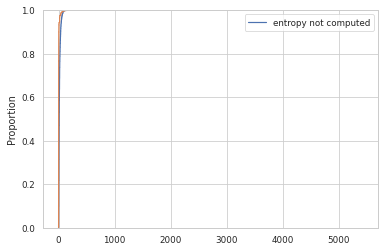

In [11]:
sns.ecdfplot(nan_regions, label="entropy not computed")
sns.ecdfplot(not_nan_regions)
plt.legend()
# sns.histplot(not_nan_regions)

In [ ]:
bins = 25
plt.hist(nan_regions[nan_regions < 200], bins=bins, alpha=.5, label="entropy not computed")
# plt.hist(not_nan_regions, bins=bins, alpha=.5, label="entropy computed")
plt.tight_layout()
plt.show()

In [ ]:
y = [(nan_regions <= i).mean() for i in range(1, 21)]
x = np.arange(1, 21)


In [ ]:
plt.plot(x, y)
plt.xlim(1, 21)
plt.ylim(0, 1)
plt.xticks(x)
plt.yticks(np.linspace(0, 1, 11))
plt.tight_layout()
plt.grid(.3)
plt.xlabel("gap length (150bp windows)")
plt.ylabel("cumulative distribution function")
plt.savefig("figures/empty_regions_lengths.jpg", dpi=200)

In [ ]:
a = np.arange(1, 4).reshape(-1, 1)
b = np.arange(100, 103).reshape(-1, 1)
c = np.arange(3, 6).reshape(-1, 1)
d = np.concatenate([a, b, c], axis=1)
np.concatenate([d, d])

In [ ]:
entropy = pyBigWig.open("human_informme_results/NME-colon_normal.bw")
clf = pyBigWig.open("human_informme_results/ENTR-colon_normal.bw")

In [ ]:
plt.figure(figsize=(6, 4.5))
clf_values = np.array(clf.intervals("chr1"))[:, 2]
entr_values = np.array(entropy.intervals("chr1"))[:, 2]
borders = []
for i in [-2, -1, 0, 1, 2]:
    borders.append(entr_values[clf_values == i].min())
    plt.hist(entr_values[clf_values == i], label=f"classified as {i}")
plt.legend()

In [ ]:
print(borders)


In [61]:
filename

'NME-muscle'

In [13]:
dir = "zebrafish informme"
for filename in os.listdir(dir):
    entropy = pyBigWig.open(f"{dir}/{filename}")
    filename = os.path.splitext(filename)[0]
    header = entropy.chroms()
    entropy_filled = pyBigWig.open(f"{dir}/{filename}-filled.bw", "w")
    entropy_filled.addHeader(list(header.items()))

    for chr in header:
        intervals = np.array(entropy.intervals(chr))
        to_add_for_chromosome = []
        for i in tqdm(range(len(intervals) - 1)):
            end_prev = intervals[i, 1]
            start_next = intervals[i + 1, 0]
            if start_next - end_prev > 1:
                num_intervals_to_add = int((start_next - end_prev - 1) // 150)
                starts = np.linspace(end_prev + 1, start_next - 150, num_intervals_to_add).reshape(-1, 1)
                ends = np.linspace(end_prev + 150, start_next - 1, num_intervals_to_add).reshape(-1, 1)
                if num_intervals_to_add <= 50:
                    values = np.linspace(intervals[i, 2], intervals[i + 1, 2], num_intervals_to_add + 2)[1:-1].reshape(-1, 1)
                else:
                    values = np.full(num_intervals_to_add, .5).reshape(-1, 1)
                to_add_for_chromosome.append(np.concatenate([starts, ends, values], axis=1))
        to_add_for_chromosome = np.concatenate(to_add_for_chromosome)
        res = np.concatenate([to_add_for_chromosome, intervals])

        if intervals[0, 0] > 0:
            res = np.concatenate([res, np.array([0, intervals[0, 0] - 1, .5]).reshape(1, -1)])
        if intervals[-1, 1] < header[chr]:
            res = np.concatenate([res, np.array([intervals[-1, 1] + 1, header[chr], .5]).reshape(1, -1)])

        res = res[res[:, 0].argsort()]

        entropy_filled.addEntries([chr] * len(res), 
                                  res[:, 0].astype(int), 
                                  res[:, 1].astype(int), 
                                  res[:, 2])
    entropy_filled.close()

100%|██████████| 223295/223295 [00:05<00:00, 38657.46it/s]
